In [1]:
import pandas as pd
import numpy as np

import random

import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss

import matplotlib.pyplot as plt
import seaborn as sns
import gc
import utils 

plt.style.use('ggplot')
%matplotlib inline

C:\ProgramData\Anaconda3\lib\site-packages\nose\config.py:178: DeprecationWarning: invalid escape sequence \.
  """


In [ ]:
def clean_data(data):
    data.loc[data["ap_hi"] < 0, "ap_hi"] *= -1
    data.loc[data["ap_lo"] < 0, "ap_lo"] *= -1
    
    data.loc[(data["ap_hi"] < 20) & (data["ap_hi"] > 10), "ap_hi"] *= 10
#      data.loc[(data["ap_lo"] < 10) & (data["ap_lo"] > 2), "ap_lo"] *= 10
    data.loc[(data["ap_lo"] < 10) & (data["ap_lo"] > 2), "ap_lo"] *= 10
    
    data.loc[(data["ap_lo"] == 120) & (data["ap_hi"] == 80), ["ap_hi", "ap_lo"]] = [120, 80]
    
    idx = (data['height']<100) & (data['weight']>100)
    data.loc[idx, ["height", "weight"]] = data.loc[idx, ["weight", "height"]].values
#     data.loc[(data["height"] < 100), "height"] += 100 alternative way...
    
    # one with 1/30 is updated manualy later
    idx = data["ap_hi"] < 2
    data.loc[idx, "ap_hi"] = 100 + data.loc[idx, "ap_lo"] // 100
    data.loc[idx, "ap_lo"] = ((data.loc[idx, "ap_lo"] % 100) // 10) * 10
    
    data.loc[(data['ap_lo'].isin([1000,1100,1200])), 'ap_lo'] //= 10
    
    data.loc[(data["ap_hi"] == 20) & (data["ap_lo"] < 120), "ap_hi"] = 120
    data.loc[(data["ap_hi"] == 20), "ap_hi"] = 200
    
    data.loc[(data['ap_lo']>250)&(data['ap_lo']//1000==8), 'ap_lo']=80 #checked
#     data.loc[(data["ap_lo"] == 30), "ap_lo"] = 60
    
#     idx = (data['ap_lo']>150)&(data['ap_lo']<300)&(data['ap_lo']>data['ap_hi'])
#     data.loc[idx, 'ap_lo'] = data.loc[idx, 'ap_lo'] % 100

    # checked
    idx = data['ap_hi'] > 10000
    data.loc[idx, 'ap_hi'] = 10 * (data.loc[idx, 'ap_hi'] // 1000)
    data.loc[data['ap_lo'] >= 10000, 'ap_lo'] //= 100
    
    data.loc[(data['ap_hi']%10!=0)&(data['ap_lo']>=250)&(data['ap_lo']<4000), 'ap_lo'] /= 10
    #--------------------------
    manual_update = [
         (42755, ['ap_hi', 'ap_lo'], [130, 90]),
         (91842, ['ap_lo'], [70]), # CHECKED
         (75399, ['ap_hi', 'ap_lo'], [240, 120]),
        
         (94426, ['ap_hi'], [160]), #116
        
#         (9482, ['ap_lo'], [90]),
#         (17260, ['ap_lo'], [90]),
#         (20438, ['ap_lo'], [100]),
#         (33191, ['ap_lo'], [70]),
#         (47030, ['ap_lo'], [90]),
#         (59157, ['ap_lo'], [70]),
#         (62058, ['ap_lo'], [80]),
#         (75482, ['ap_lo'], [80]),
#         (95886, ['ap_lo'], [70]),
#         (10586, ['ap_lo'], [100]),
#         (26985, ['ap_lo'], [90]),
#         (45450, ['ap_lo'], [70]),
#         (63276, ['ap_lo'], [100]),
        
         (357, ['ap_lo'], [80]),
         (10644, ['ap_lo'], [90]),
         (12626, ['ap_lo'], [80]),
         (14728, ['ap_lo'], [80]),
         (15529, ['ap_lo'], [70]),
         (21573, ['ap_lo'], [70]),
         (22240, ['ap_lo'], [70]),
         (23523, ['ap_lo'], [80]),
         (24824, ['ap_lo'], [80]),
         (28435, ['ap_lo'], [80]),
         (30356, ['ap_lo'], [70]),
         (31790, ['ap_lo'], [80]),
         (32517, ['ap_lo'], [80]),
         (36862, ['ap_lo'], [70]),
         (44828, ['ap_lo'], [80]),
         (45318, ['ap_lo'], [80]),
         (54612, ['ap_lo'], [80]),
         (54656, ['ap_lo'], [80]),
         (58298, ['ap_lo'], [80]),
         (64128, ['ap_lo'], [90]),
         (66175, ['ap_lo'], [80]),
         (71695, ['ap_lo'], [90]),
         (77262, ['ap_lo'], [80]),
         (80714, ['ap_lo'], [70]),
         (81683, ['ap_lo'], [90]),
         (88752, ['ap_lo'], [90]),
         (91198, ['ap_lo'], [90]),
         (91794, ['ap_lo'], [80]),
         (91933, ['ap_lo'], [85]),
         (97190, ['ap_lo'], [70]),
         (99006, ['ap_lo'], [60]),
         (8441, ['ap_lo'], [90]),
         (9094, ['ap_lo'], [80]),
         (22568, ['ap_lo'], [80]),
         (52172, ['ap_lo'], [80]),
         (52887, ['ap_lo'], [70]),
         (60834, ['ap_lo'], [70]),
         (71645, ['ap_lo'], [80]),
         (72054, ['ap_lo'], [80]),
         (94959, ['ap_lo'], [80]),
         (97818, ['ap_lo'], [70]),
        #-------------------
#         (91933, ['ap_hi', 'ap_lo'], [130, 85]),
#         (97818, ['ap_hi', 'ap_lo'], [110, 70]),
        
#         (12494, ['ap_hi', 'ap_lo'], [120, 80]),
#         (51749, ['ap_hi', 'ap_lo'], [120, 80]),
        
#         (75399, ['ap_hi', 'ap_lo'], [120, 80]),
        
#         (9482 , ['ap_lo'], [90]),
#         (20438, ['ap_lo'], [100]),
#         (22832, ['ap_lo'], [80]),
#         (29821, ['ap_lo'], [100]),
#         (33191, ['ap_lo'], [70]),
#         (62058, ['ap_lo'], [80]),
#         (62921, ['ap_lo'], [80]),
#         (75482, ['ap_lo'], [80]),
#         (95886, ['ap_lo'], [70]),
#         (10586, ['ap_lo'], [100]),
#         (26985, ['ap_lo'], [90]),
#         (45450, ['ap_lo'], [70]),
#         (50848, ['ap_lo'], [100]),
#         (63276, ['ap_lo'], [90]),
#         (74784, ['ap_lo'], [80]),
# #         (10586, ['ap_lo'], [100]),
#         (57993, ['ap_lo'], [90]),
        
#         (11089, ['ap_hi'], [150]),
#         (56466, ['ap_hi'], [140]),
        
#         (2654 ,['ap_hi'], [90]),
#         (12710 ,['ap_hi'], [140.0]),
#         (13616 ,['ap_hi'], [70.0]),
#         (19827 ,['ap_hi'], [150.0]),
#         (36793 ,['ap_hi'], [140.0]),
#         (40239 ,['ap_hi'], [160.0]),
#         (52725 ,['ap_hi'], [130.0]),
#         (58349 ,['ap_hi'], [140.0]),
#         (58728 ,['ap_hi'], [120.0]),
#         (61618 ,['ap_hi'], [140.0]),
#         (61725 ,['ap_hi'], [140.0]),
#         (62154 ,['ap_hi'], [130.0]),
#         (69672 ,['ap_hi'], [140.0]),
#         (77010 ,['ap_hi'], [90.0]),
#         (81769 ,['ap_hi'], [130.0]),
#         (82660 ,['ap_hi'], [110.0]),
#         (91364 ,['ap_hi'], [120.0]),
#         (99089 ,['ap_hi'], [200.0]),
#         (1079 ,['ap_hi'], [140.0]),
#         (35256 ,['ap_hi'], [150.0]),
#         (44904 ,['ap_hi'], [140.0]),
        
        
#         (11089, ['ap_hi'], [115]),
        
    ]
    for idx, cols, update in manual_update:
        data.loc[data['id']==idx, cols] = update
        
#     data.loc[(data['ap_lo']>300) & (data['ap_lo']<3000), 'ap_lo'] //= 10
# #     data.loc[(data['ap_lo']<1), 'ap_lo'] = np.nan
# #     data.loc[(data['ap_hi']<10), 'ap_hi'] = np.nan
    
#     data.loc[(data['ap_lo']>300)&((data['ap_lo']//100)%10==0), 'ap_lo'] //= 100
#     data.loc[(data['ap_lo']<20), 'ap_lo'] *= 10
#     data.loc[(data['ap_lo']<20), 'ap_lo'] *= 10 # for ap_lo = 1.0
    
#     data.loc[(data['ap_hi']==20), 'ap_hi'] = 120
#     data.loc[(data['ap_hi']<20), 'ap_hi'] *= 10
    
#     idx = data['ap_hi'] > 10000
#     data.loc[idx, 'ap_hi'] = 10 * (data.loc[idx, 'ap_hi'] // 1000)
    
#     idx = data['ap_lo'] > 10000
#     data.loc[idx, 'ap_lo'] = 10 * (data.loc[idx, 'ap_lo'] // 1000)
    
#     idx = (250<data['ap_hi'])&(data['ap_hi']%10>5)
#     data.loc[idx, 'ap_lo'] = 10 * (data.loc[idx, 'ap_hi'] % 10)
#     data.loc[idx, 'ap_hi'] //= 10
    
    
#     data["temp_column"] = data["ap_lo"]
#     idx = data["ap_hi"] < data["ap_lo"]
#     data.loc[idx, "ap_lo"] = data.loc[idx, "ap_hi"]
#     data.loc[idx, "ap_hi"] = data.loc[idx, "temp_column"]
#     data = data.drop('temp_column', axis=1)
    
# #     data.loc[data['height']<100, 'height'] += 100

# #     data.loc[(data['height']==data['ap_hi'])
# #             &(data['weight']==data['ap_lo'])
# #             &((data['weight']%10!=0)|(data['height']%10!=0)), ['ap_hi', 'ap_lo']]=np.nan
    
# #     data.loc[(data['height']==data['ap_hi'])
# #             &(data['weight']==data['ap_lo']), ['height', 'weight']]=np.nan

    return data

def new_features(data):
    
    data["BMI"] = 10000 * data["weight"] / (data["height"] * data["height"])
    data["ap_dif"] = data["ap_hi"] - data["ap_lo"]
    data["MAP"] = data["ap_lo"] + data["ap_dif"] / 3.0
    
    data["age_years"] = np.round(data["age"] / 365)
    
    age_bins = [0, 10000, 14000, 14980, 15700, 16420, 17140, 17890, 18625, 19355, 20090, 20820, 21555, 22280, 22990, 24000]
    age_names = [25, 30, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64]
    data["age_group"] = pd.cut(data['age'], age_bins, labels=age_names)
    
#     columns_to_interact = [
#         'gender',
#         'height',
#         'weight',
#         'ap_hi',
#         'ap_lo',
#         'cholesterol',
#         'gluc',
#         'smoke',
#         'alco',
#         'active',
#         'BMI',
#         'ap_dif',
#         'age_years',
#     ]
#     data = pd.concat((data, generate_interactions(data, columns_to_interact, 2)), axis=1)
    return data

In [ ]:
train = pd.read_csv('train.csv', sep=';')
test = pd.read_csv('test.csv', sep=';', na_values='None')

# clear train
#train = train.loc[train["height"] < 249]
# train.reset_index(inplace=True, drop=True)

train = clean_data(train)
test = clean_data(test)

train = new_features(train)
test = new_features(test)
#---------------------------------------
a = train['age_group']
# a.loc[a<3]=3
b = train['gender']
c = pd.qcut(train['height'] / train['weight'], 10, labels=False)
# d = pd.qcut(, 10, labels=False)
# d = pd.Series(y_train)
rew = a.apply(str) + b.apply(str) + c.apply(str) #+ d.apply(str)
rew.loc[rew.isin((rew).value_counts()[(rew).value_counts()<2].index)] = "hacky"
#----------------------------------------

X_train = train.drop([ 'cardio'], axis=1)
y_train = train['cardio'].values.ravel()
X_test = test.drop([], axis=1)

columns_to_interact = ['age_group', 'gender', 'MAP']
temp = utils.generate_interactions(X_train, columns_to_interact, 2)
X_train = pd.concat((X_train, temp), axis=1)
X_test = pd.concat((X_test, utils.generate_interactions(X_test, columns_to_interact, 2)), axis=1)
print(temp.columns)

X = pd.concat((X_train, X_test), axis=0)

from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
label_encoder_dict = defaultdict(LabelEncoder)
columns_to_encode = ['age_group'] + list(temp.columns)



X[columns_to_encode].apply(lambda x: label_encoder_dict[x.name].fit(x))
X_train[columns_to_encode] = X_train[columns_to_encode].apply(lambda x: label_encoder_dict[x.name].transform(x))
X_test[columns_to_encode] = X_test[columns_to_encode].apply(lambda x: label_encoder_dict[x.name].transform(x))

In [414]:
from sklearn.model_selection import train_test_split
__, idx = train_test_split(list(range(X_train.shape[0])), test_size=0.101, random_state=42)
X_train.loc[idx, 'alco'] = np.nan
__, idx = train_test_split(list(range(X_train.shape[0])), test_size=0.101, random_state=43)
X_train.loc[idx, 'smoke'] = np.nan
__, idx = train_test_split(list(range(X_train.shape[0])), test_size=0.096, random_state=44)
X_train.loc[idx, 'active'] = np.nan

# X_test.loc[X_test['smoke'].isnull(), 'smoke'] = 0
# X_test.loc[X_test['alco'].isnull(), 'alco'] = 0
# X_test.loc[X_test['active'].isnull(), 'active'] = 1

# X_train.loc[X_train['smoke'].isnull(), 'smoke'] = 0
# X_train.loc[X_train['alco'].isnull(), 'alco'] = 0
# X_train.loc[X_train['active'].isnull(), 'active'] = 1

In [415]:
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import scale
from sklearn.model_selection import cross_val_score
from sklearn.base import clone

def impute_nans(model, X_train, X_test, columns, target, perform_cv = False, scoring='accuracy'):
    X = pd.concat((X_train, X_test), axis=0)
    train_idx = ~X[target].isnull()
    model = clone(model)
    model.fit(X.loc[train_idx, columns], X.loc[train_idx, target])
    X_train.loc[X_train[target].isnull(), target] = model.predict(X_train.loc[X_train[target].isnull(), columns])
    X_test.loc[X_test[target].isnull(), target] = model.predict(X_test.loc[X_test[target].isnull(), columns])
    
    if perform_cv:
        n_folds = 7
        kf = StratifiedKFold(random_state=111, n_splits=n_folds, shuffle=True)
        scores = cross_val_score(model, X.loc[train_idx, columns], X.loc[train_idx, target], cv=kf, scoring=scoring)
        print(target, np.mean(scores), 'on', n_folds, 'folds', 'with mean on train', X.loc[train_idx, target].mean())
    
params = {
    'colsample_bytree': 0.8,
    #'gamma': 0.125,
    'learning_rate': 0.1,
    # 'max_depth': 9,
    # 'min_child_weight': 1,
    'n_estimators': 200,
    'subsample': 0.8,
    # 'reg_alpha': 0.0,
    # 'reg_lambda': 2.0,
    
    'n_jobs': 1,
    'random_state': 2707,
    'silent': True,
}
clf = xgb.XGBClassifier(**params)#KNeighborsClassifier(n_neighbors=400)

columns = ['age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc','BMI', 'ap_dif', 'MAP']
impute_nans(clf, X_train, X_test, columns, 'smoke')#, perform_cv = True)

columns = ['age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc','BMI', 'ap_dif', 'MAP', ]
impute_nans(clf, X_train, X_test, columns, 'alco')#, perform_cv = True)

columns = ['age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo', 'cholesterol', 'gluc','BMI', 'ap_dif', 'MAP', ]
impute_nans(clf, X_train, X_test, columns, 'active')#, perform_cv = True)

X = pd.concat((X_train, X_test), axis=0)
# smoke 0.921868749424 on 7 folds with mean on train 0.08797552836484983
# alco 0.945594498972 on 7 folds with mean on train 0.05420527480839609
# active 0.804708846365 on 7 folds with mean on train 0.804631401922928

# alco 0.945572255743 on 7 folds with mean on train 0.05420527480839609
# smoke 0.92183538025 on 7 folds with mean on train 0.08797552836484983
# active 0.804764170175 on 7 folds with mean on train 0.804631401922928

In [361]:
X_train['target'] = y_train
X_test['target'] = -1
X = pd.concat((X_train, X_test), axis=0)
# X.loc[(X['ap_lo']<15)&(X['ap_lo']>2)]

In [406]:
# X.loc[(X['ap_lo']>200)&((X['ap_lo']%100).isin([11,22,33,44,55,66,77,88,99]))]
# X.loc[(X['ap_lo']>100)&(X['ap_lo']<300)&(X['ap_lo']>X['ap_hi'])]
X.loc[(X['ap_hi']%5!=0), ['id', 'ap_hi', 'ap_lo', 'age_group', 'target']]

,id,ap_hi,ap_lo,age_group,target
94,127,133,89,4,NaN
358,500,122,80,10,NaN
423,604,169,109,12,NaN
439,625,126,84,10,NaN
499,716,158,91,12,NaN
598,859,123,80,2,NaN
697,986,161,73,13,NaN
783,1092,147,84,11,NaN
966,1342,137,86,14,NaN
972,1350,153,87,12,NaN


In [403]:
# X.loc[(X['ap_lo']>=4000), ['id', 'ap_hi', 'ap_lo', 'age_group', 'target']]
X.loc[(X['ap_hi']%10!=0)&(X['ap_lo']>=250)&(X['ap_lo']<4000), ['id', 'ap_hi', 'ap_lo', 'age_group', 'target']]

,id,ap_hi,ap_lo,age_group,target
3145,4442,159,1044,13,NaN
6695,9548,178,1033,11,NaN
8343,11911,165,1008,4,NaN
10144,14462,136,1022,5,NaN
12310,17575,142,1011,10,NaN
14096,20113,181,1177,12,NaN
17438,24912,168,1110,11,NaN
17825,25474,164,1088,13,NaN
18085,25829,158,1077,7,NaN
25484,36367,155,1111,11,NaN


In [404]:
X.loc[(X['ap_hi']%10==0)&(X['ap_lo']>=250)&(X['ap_lo']<4000), ['id', 'ap_hi', 'ap_lo', 'age_group', 'target']]

,id,ap_hi,ap_lo,age_group,target
473,680,150,1033,3,NaN
1033,1438,150,1001,4,NaN
2423,3415,160,1001,11,NaN
13637,19466,150,1007,11,NaN
13686,19536,160,1001,12,NaN
14241,20336,170,1177,8,NaN
18198,25994,180,1120,9,NaN
19831,28314,150,1125,11,NaN
20469,29218,150,1008,7,NaN
22599,32286,160,1110,10,NaN


In [383]:
X.loc[(X['ap_lo']>250)&(X['ap_lo']//1000==8)]
# X.loc[(X['ap_lo']>250)&(X['ap_lo']//1000==9)]
# X.loc[(X['ap_lo']>250)&(X['ap_lo']//1000==6)]
X.loc[(X['ap_lo']>=250)]
X.loc[(X['ap_hi']==130)&(X['target']==0)&(X['age_group']==11), 'ap_lo'].mean()

82.43099273607749

In [184]:
# X.loc[(X['ap_lo']<1000)&(X['ap_lo']>200),'ap_lo'].hist(bins=500)

In [416]:
import utils
params = {
    'colsample_bytree': 0.8,
    #'gamma': 0.125,
    'learning_rate': 0.1,
    # 'max_depth': 9,
    # 'min_child_weight': 1,
    'n_estimators': 200,
    'subsample': 0.8,
    # 'reg_alpha': 0.0,
    # 'reg_lambda': 2.0,
    
    'n_jobs': 1,
    'random_state': 2707,
    'silent': True,
}

utils.execute_model(xgb.XGBClassifier(**params),
              X_train,
              y_train,
              X_test,
              model_name="test_model",
              mean_columns = ['age_group_gender'],# 'age_group_MAP', 'gender_MAP'],
              drop_columns=["id", 'age_group', 'age_group_gender', 'age_group_MAP', 'gender_MAP', 'age_years'],
              n_splits=15,
              n_folds=10,
#               stratification_groups=rew,
              alpha=10
             )


10 folds logloss:
[0.53307813326768583, 0.54405590886227317, 0.54903744810208366, 0.53628504976714175, 0.53739087670309793, 0.52543756742828518, 0.54260443357813737, 0.54528064945905153, 0.53657876534090965, 0.53507394865116187]
mean: 0.538482278116
std: 0.00652928242809
15 Splits logloss:
[0.53896015321139434, 0.54245263325851045, 0.53930107966450791, 0.5331557776552095, 0.54313935224133492, 0.53291558855729071, 0.538095646056022, 0.53408229046573807, 0.53846144586381706, 0.53863866979132413, 0.53640646453372709, 0.54274150900766904, 0.5374685463265847, 0.54014178938561663, 0.53510739518688688]
mean: 0.538071222747
std: 0.00318676203916
test_model results saved!


(0.53848227811598282, 0.53807122274704233)

In [ ]:
10 folds logloss:
[0.53298878081022638, 0.54452346784312433, 0.54930256425065027, 0.53625442462006734, 0.53747480018239902, 0.525146873939905, 0.54274992873410899, 0.54510328201335612, 0.53627167349996641, 0.53535950476014627]
mean: 0.538517530065
std: 0.00666514080224
15 Splits logloss:
[0.53889403679655923, 0.54237992497776244, 0.53946292807484442, 0.53316062905898987, 0.54322481893096708, 0.53299141980430609, 0.53795846158094829, 0.53371191452966882, 0.53845949588350894, 0.53848661369423045, 0.53663012631853646, 0.54287750031779924, 0.53763061020972869, 0.54017026180114103, 0.53520939434971293]
mean: 0.538083209089
std: 0.00321414920272

In [417]:
import lightgbm as lgb
params = {
    'colsample_bytree': 0.8,
    'learning_rate': 0.1,
#     'num_leaves': 2**3,
#     'min_child_weight': 1,
    'n_estimators': 50,
    'subsample': 0.8,
#     'reg_alpha': 1.2,
#     'reg_lambda': 0.0,
       
    'nthread': 1,
    'seed': 2707,
    'silent': True,
}

utils.execute_model(lgb.LGBMClassifier(**params),
              X_train,
              y_train,
              X_test,
              model_name="test_model_lgb",
              mean_columns = ['age_group_gender'],# 'age_group_MAP', 'gender_MAP'],
              drop_columns=["id", 'age_group', 'age_group_gender', 'age_group_MAP', 'gender_MAP', 'age_years'],
              n_splits=15,
              n_folds=10,
#               stratification_groups=rew,
              alpha=10
             )


10 folds logloss:
[0.53301352263672519, 0.54387540603518492, 0.55008767836165418, 0.5360228456332331, 0.53788412725685131, 0.52594341089256724, 0.5415483205994408, 0.54519946915626116, 0.53373328176865642, 0.53507728976799362]
mean: 0.538238535211
std: 0.00667369681542
15 Splits logloss:
[0.53798720910112285, 0.54197084875520629, 0.5394390489159584, 0.53338835114699901, 0.54314714950636389, 0.53290341310302602, 0.53721386328257859, 0.53401258691409104, 0.53845986225272024, 0.53832673909778339, 0.53625818610495934, 0.54248892300875451, 0.53738362631483638, 0.53984694030706171, 0.5345791160662039]
mean: 0.537827057592
std: 0.0031266519194
test_model_lgb results saved!


(0.53823853521085685, 0.53782705759184435)

In [ ]:
10 folds logloss:
[0.53282875192944179, 0.54389873036075476, 0.54987591691822957, 0.53592107300701652, 0.53795714557554952, 0.52608103602627043, 0.54151243048686615, 0.5446665885031543, 0.53454877423626745, 0.53461455996745921]
mean: 0.538190500701
std: 0.00654789686683
15 Splits logloss:
[0.53792653643131694, 0.5420368337385395, 0.53928500847379701, 0.53307815211447229, 0.54303564441710039, 0.5328592855164006, 0.53702670836073618, 0.53408602197191157, 0.53834349955878735, 0.53849850513726394, 0.53617454486490113, 0.5422964976044643, 0.53728055540035813, 0.53988712032210551, 0.53450070461343846]
mean: 0.537754374568
std: 0.00313906598763

In [6]:
from keras.layers.core import Dense, Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential
from keras.optimizers import Adamax
from sklearn.preprocessing import  StandardScaler


class KerasModel(object):
    def __init__(self,variables, epoche):
        self.scaler = StandardScaler()
        self.epoche = epoche
        self.model = Sequential()
        model = self.model

        model.add(Dense(60,input_dim=len(variables)))
        model.add(LeakyReLU())
        model.add(Dropout(0.09))

        model.add(Dense(30,input_dim=len(variables)))
        model.add(LeakyReLU())
        model.add(Dropout(0.06))


        model.add(Dense(1, activation='sigmoid'))
        opt = Adamax(lr=0.1)

        model.compile(loss='binary_crossentropy', optimizer=opt)



    def fit_process(self,X, Y):
        self.scaler.fit(X)

    def process(self,X):
        return self.scaler.transform(X)


    def fit(self, X,y, sample_weight=None, callbacks=[]):
        process_X = self.process(X)
        process_y = y
        self.model.fit(process_X, process_y, batch_size=512,
                       epochs=self.epoche, verbose=0,
                       sample_weight=sample_weight,
                       callbacks=callbacks,
                       validation_split=0.02,
                       shuffle=True)

    def predict_proba(self, X):
        process_x = self.process(X)
        result  = self.model.predict(process_x)
        return result

Using Theano backend.


In [7]:
def create_keras(tr, ts):
    model = KerasModel(tr.columns, 600)
    model.fit_process(pd.concat((tr,ts), axis=0), y_train)
    return model

In [8]:
utils.execute_model(None,
              X_train,
              y_train,
              X_test,
              model_name="test_model_keras",
              mean_columns = ['age_group_gender'],# 'age_group_MAP', 'gender_MAP'],
              drop_columns=["id", 'age_group', 'age_group_gender', 'age_group_MAP', 'gender_MAP', 'age_years'],
              n_splits=15,
              n_folds=10,
              stratification_groups=rew,
              alpha=10,
              create_callback=create_keras
             )

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:581: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)



10 folds logloss:
[0.54487535759095829, 0.54147982365853986, 0.54773689544719761, 0.54959847808664619, 0.54273092540114309, 0.55304213897143262, 0.58045871480904032, 0.54066752386993089, 0.56418127648191729, 0.57147878722542667]
mean: 0.553624992154
std: 0.013084731264
15 Splits logloss:
[0.54991905032766075, 0.54806002041309343, 0.55402546475700598, 0.5551532303255774, 0.55221154498894431, 0.55409361033053239, 0.55837155425325924, 0.54984104011707535, 0.54777983702630217, 0.55041621050330147, 0.5531851880390235, 0.5489268470042038, 0.55197058324608506, 0.54735219843403482, 0.55421585389715244]
mean: 0.551701482244
std: 0.00305426774339
test_model_keras results saved!


(0.55362499215422334, 0.55170148224421678)

In [183]:
X.loc[(X['ap_dif']<10)&(X['ap_dif']>0)]

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,BMI,ap_dif,MAP,age_years,age_group,age_group_gender,age_group_MAP,gender_MAP
21014,30014,21200,1,158,56.0,90,85,1,1,0.0,0.0,1.0,22.432303,5,86.666667,58.0,11,22,1311,271
21395,30564,18340,1,153,67.0,105,96,1,1,0.0,0.0,0.0,28.621470,9,99.000000,50.0,7,14,674,310
52851,75399,17770,2,164,64.0,24,20,3,1,0.0,0.0,1.0,23.795360,4,21.333333,49.0,6,13,465,426
27294,91106,17553,1,166,64.0,100,98,3,3,0.0,0.0,1.0,23.225432,2,98.666667,48.0,6,12,510,309


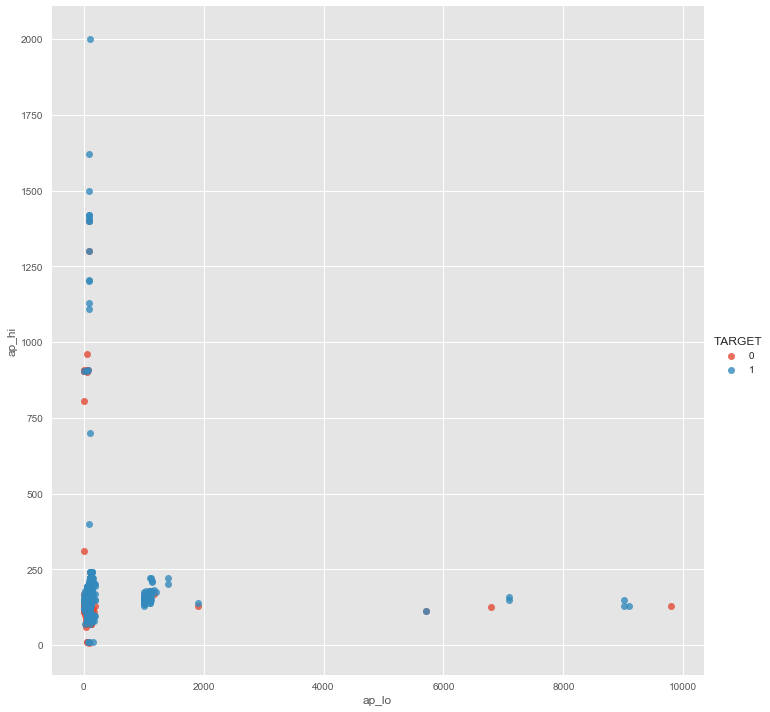

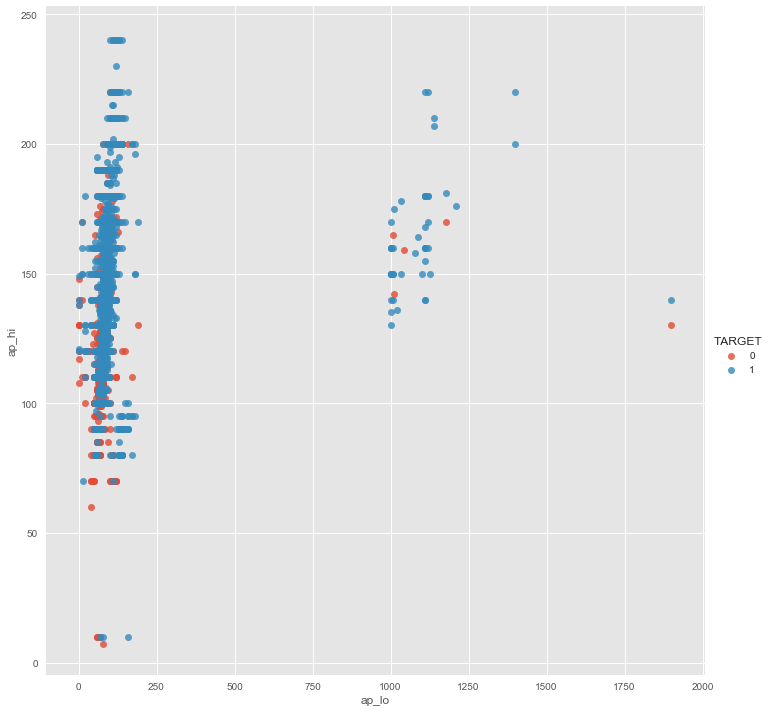

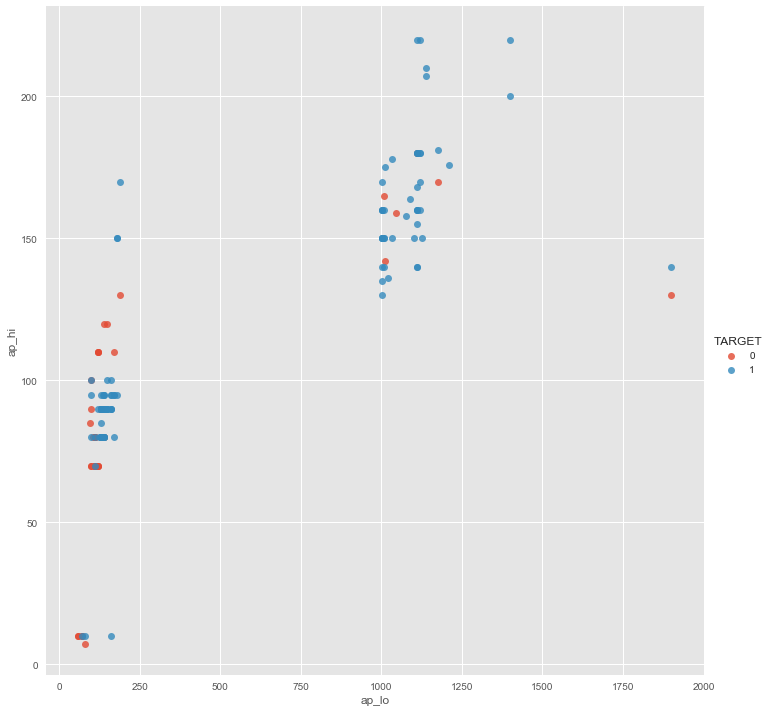

In [357]:
XP = X_train.copy()
XP['TARGET'] = y_train
sns.lmplot(x='ap_lo', y='ap_hi', data=XP, hue='TARGET', fit_reg=False, size=10)
XP=XP.loc[(XP['ap_hi']<300)&(XP['ap_lo']<4000)]
sns.lmplot(x='ap_lo', y='ap_hi', data=XP, hue='TARGET', fit_reg=False, size=10)
# XP=XP.loc[(XP['TARGET']==0)]
# sns.lmplot(x='ap_lo', y='ap_hi', data=XP, hue='TARGET', fit_reg=False, size=10)
XP=XP.loc[(XP['ap_hi']<=XP['ap_lo'])]
sns.lmplot(x='ap_lo', y='ap_hi', data=XP, hue='TARGET', fit_reg=False, size=10)

In [ ]:
import utils
kf = StratifiedKFold(random_state=1205, n_splits=10, shuffle=True)
fold_logloss = []
train_predict = np.zeros(X_train.shape[0])
for i, (train_idx, test_idx) in enumerate(kf.split(X_train, y_train)):
    if i != 2:
        continue
    train_predict[test_idx] = utils.fit_predict_model(xgb.XGBClassifier(**params),
                                                X_train.iloc[train_idx],
                                                y_train[train_idx],
                                                X_train.iloc[test_idx],
                                                mean_columns = ['age_group_gender', 'age_group_MAP'],
                                                drop_columns=["id",'age_group', 'age_group_gender', 'age_group_MAP', 'gender_MAP', 'age_years'],
                                                alpha=10)
    if i == 2:
        break
    fold_logloss.append(log_loss(y_train[test_idx], train_predict[test_idx]))
print(fold_logloss)

In [ ]:
log_loss(y_train[test_idx], train_predict[test_idx])

In [ ]:
a = np.abs(y_train[test_idx]-train_predict[test_idx])
b = X_train.iloc[train_idx]
# b.loc[b['MAP']<500, 'MAP'].hist(bins=100)
# b.loc[(a>0.8), 'height'].hist(bins=200)
idx = a > 0.6

In [ ]:
b['test']=b['height']/b['weight']

In [ ]:
for c in ['cholesterol', 'gluc']:
    print(c)
    pd.qcut(b[c], 10, labels=False, duplicates='drop').hist()
    print(b[c].mean(), b.loc[idx, c].mean())
    plt.show()
    pd.qcut(b.loc[idx, c], 10, labels=False, duplicates='drop').hist()
    plt.show()

In [ ]:
b.columns

In [ ]:
b.loc[:, 'weight'].hist(bins=100)

In [80]:
pd.set_option('display.height', 1500)
pd.set_option('display.max_rows', 1500)

height has been deprecated.



In [ ]:
X_train['q']=0
X_test['q']=1
X = pd.concat((X_train, X_test), axis=0)

In [ ]:
X.loc[(X['ap_hi']<50)&(X['ap_hi']>20)]

In [ ]:
X.loc[X['ap_lo']<0]

In [ ]:
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.preprocessing import scale

knn = KNeighborsRegressor(n_neighbors=400,
#                           weights='distance',
                          algorithm='auto',
                          leaf_size=30,
                          p=2,
                          metric='minkowski'
                         )
cols = ['age', 'gender', 'height', 'weight', 'cholesterol', 'gluc', 'ap_hi', 'ap_lo']
X = pd.concat((X_train, X_test), axis=0)
idx = (X['height']<250) & (X['height']>130)&(X['ap_hi']<250)    &(X['ap_hi']>100)    &(X['ap_lo']<250)    &(X['ap_lo']>40)    &(X['ap_hi']>X['ap_lo'])    &(~X['smoke'].isnull())
idx2 = X['smoke'].isnull() # X['ap_hi']>10000
X.loc[:, cols] = scale(X.loc[:, cols])
X['test']=0

In [ ]:
knn.fit(X.loc[idx, cols], X.loc[idx, 'smoke'])

X.loc[idx2, 'test'] = knn.predict(X.loc[idx2, cols])

In [ ]:
X.loc[idx2, 'test'].mean() # предсказал

In [ ]:
X.loc[idx, 'smoke'].mean() # исходные

In [ ]:
from sklearn.model_selection import cross_val_score
knn = KNeighborsClassifier(n_neighbors=400,
#                           weights='distance',
                          algorithm='auto',
                          leaf_size=30,
                          p=2,
                          metric='minkowski'
                         )

scores = cross_val_score(knn, X.loc[idx, cols], X.loc[idx, 'smoke'], cv=5, scoring='accuracy')
np.mean(scores)

In [ ]:
from sklearn.model_selection import GridSearchCV

tuned_parameters = {'n_neighbors': [350, 375, 400, 425, 450]}
clf = GridSearchCV(knn, tuned_parameters, cv=10, scoring='neg_mean_squared_error')
clf.fit(X.loc[idx, cols], X.loc[idx, 'ap_hi'])

print("Best parameters set found on development set:")
print()
print(clf.best_params_)

In [ ]:
knn.predict(X.loc[idx2, cols])

In [ ]:
X.loc[idx2, ['ap_hi', 'ap_lo','test']]

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.manifold import TSNE
for m in ["euclidean","manhattan","chebyshev","minkowski",
          #"wminkowski",
          "seuclidean","mahalanobis",]:
    print(m)
    model = TSNE(n_components=2, random_state=0, metric=m, perplexity=22)
    np.set_printoptions(suppress=True)
    X = model.fit_transform(scale(X_train.drop(['age_group', 'age_years'], axis=1)))
    X2 = pd.DataFrame(X)
    X2["TARGET"]=y_train
    X2.columns = ["0", "1", "TARGET"]
    sns.lmplot(x="0", y="1", data=X2, hue='TARGET', size=10, fit_reg=False)
    sns.plt.show()

In [ ]:
X.loc[X['ap_lo']>10000]